In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-xgu22ywl
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-xgu22ywl
  Resolved https://github.com/huggingface/transformers to commit bdee0889714e9cb3e53d3b1b2a626919479d356c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 15.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11085249 sha256=f8e981ec623ca0ced3b8875d25613f3c3c0d0d5280dc2f6d847b9fbd7248d2d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdzyxvsm/wheels/49/a7/50/c9fdabbf10e51bb1256adb0c1a587fedd7184f5bad28d47fe3
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
 

In [6]:
from huggingface_hub import login
login()

In [3]:
!wget -O image.png "https://markomilenkovic.rs/random_media/lauzhack_1.png"

--2025-11-22 23:30:42--  https://markomilenkovic.rs/random_media/lauzhack_1.png
Resolving markomilenkovic.rs (markomilenkovic.rs)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to markomilenkovic.rs (markomilenkovic.rs)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1239409 (1.2M) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>]   1.18M  --.-KB/s    in 0.03s   

2025-11-22 23:30:43 (37.1 MB/s) - ‘image.png’ saved [1239409/1239409]



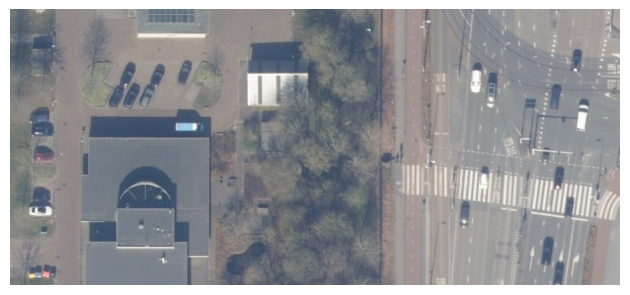

In [7]:
from pathlib import Path
from IPython.display import display
from PIL import Image


import matplotlib.pyplot as plt

p = "image.png"
image = Image.open("image.png")

plt.imshow(image)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from transformers import Sam3Processor, Sam3Model
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def compute_orientation(mask, threshold=0.5):
    """
    Estimate orientation using PCA on mask pixels.
    Returns (angle_deg, centroid_xy, major_len, minor_len) or None if empty.
    angle_deg: degrees from image +x axis (right) positive CCW.
    centroid_xy: (x, y) in image coordinates.
    """
    if torch.is_tensor(mask):
        arr = mask.cpu().numpy()
    else:
        arr = np.array(mask)

    # normalize to boolean
    if arr.dtype == np.uint8 or arr.max() > 1:
        bw = arr > 127
    else:
        bw = arr > threshold

    coords = np.column_stack(np.where(bw))  # rows (y), cols (x)
    if coords.size == 0:
        return None

    centroid = coords.mean(axis=0)  # (y, x)
    centered = coords - centroid
    if centered.shape[0] < 2:
        return None

    cov = np.cov(centered, rowvar=False)  # 2x2 cov of [y, x]
    eigvals, eigvecs = np.linalg.eigh(cov)
    # largest eigenvalue -> principal axis
    idx = np.argmax(eigvals)
    major_vec = eigvecs[:, idx]  # [vy, vx]
    # convert to (vx, vy) and normalize
    vx, vy = float(major_vec[1]), float(major_vec[0])
    norm = np.hypot(vx, vy) or 1.0
    vx /= norm; vy /= norm

    angle_rad = np.arctan2(vy, vx)
    angle_deg = np.degrees(angle_rad)

    # approximate axis lengths from eigenvalues (scale factor arbitrary)
    major_len = 2.0 * np.sqrt(max(eigvals[idx], 0.0))
    minor_len = 2.0 * np.sqrt(max(eigvals[1-idx], 0.0))

    # centroid in (x, y)
    centroid_xy = (float(centroid[1]), float(centroid[0]))
    return angle_deg, centroid_xy, major_len, minor_len

def overlay_masks(image, masks, draw_orientations=True):
    image = image.convert("RGBA")
    masks_np = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks_np.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    orientations = []
    for mask, color in zip(masks_np, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

        # compute orientation for this mask
        orient = compute_orientation(mask)
        orientations.append((orient, color))

    if draw_orientations:
        draw = ImageDraw.Draw(image)
        for item in orientations:
            orient, color = item
            if orient is None:
                continue
            angle_deg, (cx, cy), major_len, minor_len = orient
            # draw a line for the major axis (scaled for visibility)
            L = max(20, major_len * 4)
            # direction vector
            ang = np.radians(angle_deg)
            dx = np.cos(ang) * L
            dy = np.sin(ang) * L
            # image coordinates: x right, y down (PIL uses same)
            start = (cx - dx, cy - dy)
            end = (cx + dx, cy + dy)
            draw.line([start, end], fill=(255,255,255,255), width=3)
            # small circle at centroid
            r = 4
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(255,255,255,255))

    return image, orientations

def minimal_axis_angle_diff(a_deg, b_deg):
    """
    Return smallest absolute angle difference between two axial angles (degrees).
    Accounts for 180-degree axis ambiguity and returns value in [0, 90].
    """
    # minimal difference on circle
    raw = abs(((a_deg - b_deg + 180) % 360) - 180)  # in [0,180]
    if raw > 90:
        raw = 180 - raw
    return raw


device = "cuda"
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]


Detecting cars and estimating their orientations...
Initially found 28 car objects. Filtering by aspect ratio and area...
Initially found 28 car objects. Filtering by aspect ratio and area...
Found 21 car objects after filtering
Car 0: angle=-66.4°, centroid=(246.81049334377448, 203.60454189506657), major=29.4, minor=14.0
Car 1: angle=0.8°, centroid=(70.32792207792208, 467.62418831168833), major=30.0, minor=13.4
Car 2: angle=-81.8°, centroid=(1314.665409990575, 119.58152686145147), major=29.2, minor=11.8
Car 3: angle=-82.8°, centroid=(1274.1431143114312, 612.0567056705671), major=30.8, minor=12.1
Car 4: angle=-82.6°, centroid=(1274.0251207729468, 390.8589371980676), major=29.7, minor=11.5
Car 5: angle=-2.3°, centroid=(76.5464759959142, 341.1532175689479), major=24.9, minor=12.7
Car 6: angle=-69.2°, centroid=(272.7514880952381, 152.30357142857142), major=31.9, minor=13.6
Found 21 car objects after filtering
Car 0: angle=-66.4°, centroid=(246.81049334377448, 203.60454189506657), major=2

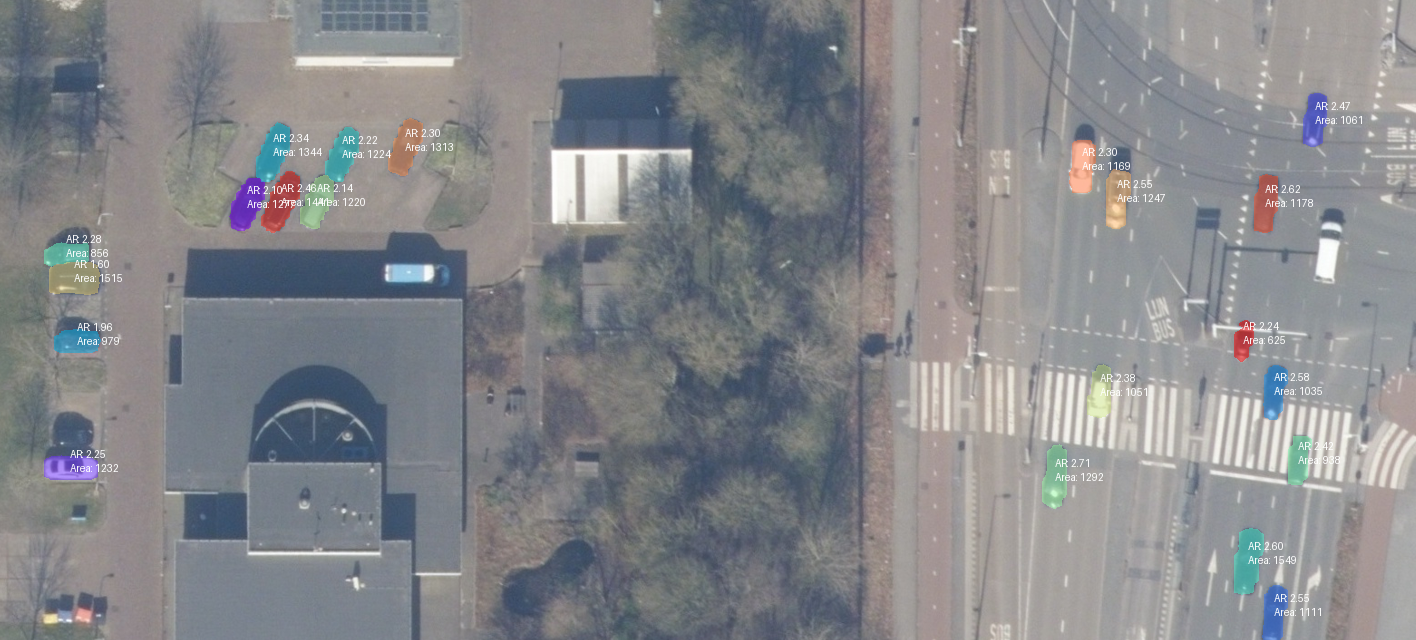

In [35]:
# detect cars and estimate orientations
from IPython.display import display
print("\nDetecting cars and estimating their orientations...")

inputs_cars = processor(images=image, text="car body", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_cars = model(**inputs_cars)

results_cars = processor.post_process_instance_segmentation(
    outputs_cars,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_cars.get("original_sizes").tolist()
)[0]

print(f"Initially found {len(results_cars['masks'])} car objects. Filtering by aspect ratio and area...")

# --- Filter by aspect ratio and area ---
keep_indices = []
min_aspect_ratio = 1.3
max_aspect_ratio = 2.8
min_area = 600  # Minimum area in pixels to be considered a car
max_area = 2000 # Maximum area in pixels to exclude trucks

for i, mask in enumerate(results_cars["masks"]):
    # Calculate area
    if torch.is_tensor(mask):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)
    
    # Check if mask is boolean or 0-1 or 0-255
    if mask_np.dtype == bool:
        area = np.sum(mask_np)
    else:
        area = np.sum(mask_np > 0)
        
    if area < min_area or area > max_area:
        continue

    orient = compute_orientation(mask)
    if orient is None:
        continue
    _, _, major_len, minor_len = orient
    if minor_len < 1.0: # Avoid division by zero
        continue
    
    aspect_ratio = major_len / minor_len
    if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
        keep_indices.append(i)

# Apply filter
results_cars["masks"] = results_cars["masks"][keep_indices]
results_cars["scores"] = results_cars["scores"][keep_indices]
if "labels" in results_cars:
    results_cars["labels"] = results_cars["labels"][keep_indices]

print(f"Found {len(results_cars['masks'])} car objects after filtering")

cars_image, car_orientations = overlay_masks(image, results_cars["masks"], draw_orientations=False)
draw = ImageDraw.Draw(cars_image)

for i, (orient, _) in enumerate(car_orientations):
    if orient is None:
        print(f"Car {i}: no mask pixels")
    else:
        # Calculate area for display
        mask = results_cars["masks"][i]
        if torch.is_tensor(mask):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = np.array(mask)
        
        if mask_np.dtype == bool:
            area = np.sum(mask_np)
        else:
            area = np.sum(mask_np > 0)

        angle_deg, centroid_xy, major_len, minor_len = orient
        print(f"Car {i}: angle={angle_deg:.1f}°, centroid={centroid_xy}, major={major_len:.1f}, minor={minor_len:.1f}")
        
        if minor_len > 0:
            ar = major_len / minor_len
            # Draw aspect ratio and area above the centroid
            text = f"AR: {ar:.2f}\nArea: {area}"
            draw.text((centroid_xy[0], centroid_xy[1] - 20), text, fill="white")

display(cars_image)

In [36]:
# --- roads detection (existing) --- #
print("\nDetecting roads and estimating their directions...")

# prepare inputs for 'roads'
inputs_roads = processor(images=image, text="street road", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_roads = model(**inputs_roads)

results_roads = processor.post_process_instance_segmentation(
    outputs_roads,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_roads.get("original_sizes").tolist()
)[0]

print(f"Found {len(results_roads['masks'])} road objects")

road_image, road_orientations = overlay_masks(image, results_roads["masks"])
# print road orientations
for i, (orient, _) in enumerate(road_orientations):
    if orient is None:
        print(f"Road {i}: no mask pixels")
    else:
        angle_deg, centroid_xy, major_len, minor_len = orient
        print(f"Road {i}: angle={angle_deg:.1f}°, centroid={centroid_xy}, major={major_len:.1f}, minor={minor_len:.1f}")


# --- compute angle differences between each car and nearest road --- #
if len(road_orientations) == 0:
    print("\nNo roads found — cannot compute car vs road angle differences.")
else:
    # build list of road centroids and angles (skip None)
    roads = [(ang, cen) for (ang, cen, *_), _ in road_orientations if ang is not None]
    if len(roads) == 0:
        print("\nNo valid road orientations found.")
    else:
        print("\nCar vs nearest-road orientation differences:")
        for i, (car_orient, _) in enumerate(car_orientations):
            if car_orient is None:
                print(f"Car {i}: no mask pixels")
                continue
            car_ang, car_centroid, *_ = car_orient
            # find nearest road by centroid distance
            best_j = None
            best_dist = float("inf")
            best_road_ang = None
            for j, (road_ang, road_centroid) in enumerate(roads):
                dx = car_centroid[0] - road_centroid[0]
                dy = car_centroid[1] - road_centroid[1]
                d = (dx*dx + dy*dy) ** 0.5
                if d < best_dist:
                    best_dist = d
                    best_j = j
                    best_road_ang = road_ang
            diff_deg = minimal_axis_angle_diff(car_ang, best_road_ang)
            print(f"Car {i}: angle={car_ang:.1f}°, nearest road angle={best_road_ang:.1f}° (road #{best_j}), diff={diff_deg:.1f}° , distance={best_dist:.1f}px")

# --- generate image with only parked cars --- #
angle_thresh = 20.0  # degrees: if car vs road diff <= this -> considered aligned
default_dist_thresh = 50.0  # px: minimum distance to consider "on road" if road major_len is tiny

# build roads info (ang, centroid, major_len)
roads_info = []
for (orient, _color) in road_orientations:
    if orient is None:
        continue
    ang, cen, major_len, _ = orient
    roads_info.append((ang, cen, max(major_len, 1.0)))

parked_indices = []
for i, (car_orient, _color) in enumerate(car_orientations):
    if car_orient is None:
        continue
    car_ang, car_centroid, car_major, _ = car_orient

    if len(roads_info) == 0:
        # no roads -> can't be "on road and aligned", so treat as parked
        parked = True
    else:
        # find nearest road
        best_d = float("inf")
        best_road_ang = None
        best_road_major = None
        for (road_ang, road_cent, road_major) in roads_info:
            dx = car_centroid[0] - road_cent[0]
            dy = car_centroid[1] - road_cent[1]
            d = (dx*dx + dy*dy) ** 0.5
            if d < best_d:
                best_d = d
                best_road_ang = road_ang
                best_road_major = road_major

        dist_thresh = max(best_road_major * 1.5, default_dist_thresh)
        on_road = best_d <= dist_thresh
        aligned = minimal_axis_angle_diff(car_ang, best_road_ang) <= angle_thresh
        # car is NOT parked if it's on the road AND aligned with the road
        parked = not (on_road and aligned)

    if parked:
        parked_indices.append(i)

print(f"\nParked car indices: {parked_indices}")

# --- CLUSTERING VEHICLES TO FIND PARKING LOTS --- #
print("\n=== Clustering vehicles to find parking lots ===")

if len(car_orientations) == 0:
    print("No cars detected - cannot find parking lots")
else:
    # Extract centroids of all cars
    car_centroids = []
    valid_car_indices = []
    
    for i, (orient, _) in enumerate(car_orientations):
        if orient is not None:
            _, centroid, _, _ = orient
            car_centroids.append(centroid)
            valid_car_indices.append(i)
    
    if len(car_centroids) < 3:
        print(f"Only {len(car_centroids)} cars found - need at least 3 for clustering")
    else:
        car_centroids = np.array(car_centroids)
        
        # DBSCAN clustering
        eps = 150  # pixels - adjust based on your image scale
        min_samples = 3  # at least 3 cars for a parking lot
        
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(car_centroids)
        labels = clustering.labels_
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"\nFound {n_clusters} vehicle clusters")
        print(f"Noise points (isolated cars): {n_noise}")
        
        # --- Analyze each cluster to determine if it's a parking lot --- #
        parking_lot_clusters = []
        
        for cluster_id in set(labels):
            if cluster_id == -1:  # skip noise
                continue
            
            # Get cars in this cluster
            cluster_mask = labels == cluster_id
            cluster_indices = [valid_car_indices[i] for i, in_cluster in enumerate(cluster_mask) if in_cluster]
            cluster_centroids = car_centroids[cluster_mask]
            
            print(f"\n--- Cluster {cluster_id} ---")
            print(f"Number of cars: {len(cluster_indices)}")
            
            # 1. Density check
            distances = []
            for i in range(len(cluster_centroids)):
                for j in range(i + 1, len(cluster_centroids)):
                    dist = np.linalg.norm(cluster_centroids[i] - cluster_centroids[j])
                    distances.append(dist)
            
            avg_distance = np.mean(distances) if distances else 0
            print(f"Average inter-car distance: {avg_distance:.1f}px")
            
            # 2. Orientation alignment
            cluster_orientations = [car_orientations[i][0] for i in cluster_indices]
            angles = [orient[0] for orient in cluster_orientations if orient is not None]
            
            if len(angles) >= 2:
                angle_diffs = []
                for i in range(len(angles)):
                    for j in range(i + 1, len(angles)):
                        diff = minimal_axis_angle_diff(angles[i], angles[j])
                        angle_diffs.append(diff)
                
                avg_angle_diff = np.mean(angle_diffs)
                print(f"Average angle difference: {avg_angle_diff:.1f}°")
            else:
                avg_angle_diff = 90
            
            # 3. Check if cars are mostly parked
            n_parked = sum(1 for i in cluster_indices if i in parked_indices)
            parked_ratio = n_parked / len(cluster_indices)
            print(f"Parked cars ratio: {parked_ratio:.2%} ({n_parked}/{len(cluster_indices)})")
            
            # 4. Compactness
            hull = ConvexHull(cluster_centroids)
            hull_area = hull.volume
            car_density = len(cluster_indices) / hull_area if hull_area > 0 else 0
            print(f"Car density: {car_density:.6f} cars/px²")
            print(f"Cluster area: {hull_area:.1f}px²")
            
            # --- Decision logic --- #
            is_parking_lot = True
            reasons = []
            
            if len(cluster_indices) < 3:
                is_parking_lot = False
                reasons.append("too few cars")
            
            if avg_distance > 200:
                is_parking_lot = False
                reasons.append("cars too spread out")
            
            if parked_ratio < 0.6:
                is_parking_lot = False
                reasons.append(f"only {parked_ratio:.0%} are parked")
            
            if avg_angle_diff < 30:
                reasons.append("parallel parking pattern detected")
            elif avg_angle_diff > 70:
                reasons.append("random orientations (perpendicular or angled parking)")
            
            if car_density < 0.00001:
                is_parking_lot = False
                reasons.append("too sparse")
            
            print(f"\n{'✓' if is_parking_lot else '✗'} Parking lot: {is_parking_lot}")
            if reasons:
                print(f"Reasons: {', '.join(reasons)}")
            
            if is_parking_lot:
                parking_lot_clusters.append({
                    'cluster_id': cluster_id,
                    'car_indices': cluster_indices,
                    'centroids': cluster_centroids,
                    'n_cars': len(cluster_indices),
                    'parked_ratio': parked_ratio,
                    'avg_angle_diff': avg_angle_diff,
                    'hull': hull
                })
        
        # --- Visualize parking lots --- #
        if len(parking_lot_clusters) == 0:
            print("\n❌ No parking lots detected")
        else:
            print(f"\n✓ Found {len(parking_lot_clusters)} parking lot(s)!")
            
            parking_lot_image = image.copy().convert("RGBA")
            draw = ImageDraw.Draw(parking_lot_image)
            
            lot_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), 
                          (255, 255, 0), (255, 0, 255), (0, 255, 255)]
            
            for i, lot in enumerate(parking_lot_clusters):
                color = lot_colors[i % len(lot_colors)]
                
                hull_points = lot['centroids'][lot['hull'].vertices]
                hull_coords = [(int(x), int(y)) for x, y in hull_points]
                draw.polygon(hull_coords, outline=color + (200,), width=5)
                
                for car_idx in lot['car_indices']:
                    orient, _ = car_orientations[car_idx]
                    if orient is not None:
                        _, (cx, cy), _, _ = orient
                        r = 8
                        draw.ellipse([cx-r, cy-r, cx+r, cy+r], 
                                   fill=color + (255,), outline=(255,255,255,255))
                
                centroid = lot['centroids'].mean(axis=0)
                label = f"Lot {i+1}: {lot['n_cars']} cars"
                draw.text((centroid[0], centroid[1]), label, 
                         fill=(255, 255, 255, 255))
            
            print("\n=== Parking Lot Summary ===")
            for i, lot in enumerate(parking_lot_clusters):
                print(f"Lot {i+1}: {lot['n_cars']} cars, "
                      f"{lot['parked_ratio']:.0%} parked, "
                      f"avg orientation diff: {lot['avg_angle_diff']:.1f}°")


Detecting roads and estimating their directions...
Found 1 road objects
Road 0: angle=-80.5°, centroid=(1172.1252740393993, 308.80081919251023), major=359.4, minor=249.1

Car vs nearest-road orientation differences:
Car 0: angle=-66.4°, nearest road angle=-80.5° (road #0), diff=14.1° , distance=931.3px
Car 1: angle=0.8°, nearest road angle=-80.5° (road #0), diff=81.3° , distance=1113.2px
Car 2: angle=-81.8°, nearest road angle=-80.5° (road #0), diff=1.3° , distance=236.9px
Car 3: angle=-82.8°, nearest road angle=-80.5° (road #0), diff=2.3° , distance=320.0px
Car 4: angle=-82.6°, nearest road angle=-80.5° (road #0), diff=2.1° , distance=130.8px
Car 5: angle=-2.3°, nearest road angle=-80.5° (road #0), diff=78.2° , distance=1096.1px
Car 6: angle=-69.2°, nearest road angle=-80.5° (road #0), diff=11.3° , distance=912.9px
Car 7: angle=-68.2°, nearest road angle=-80.5° (road #0), diff=12.3° , distance=844.4px
Car 8: angle=-80.7°, nearest road angle=-80.5° (road #0), diff=0.2° , distance=262.

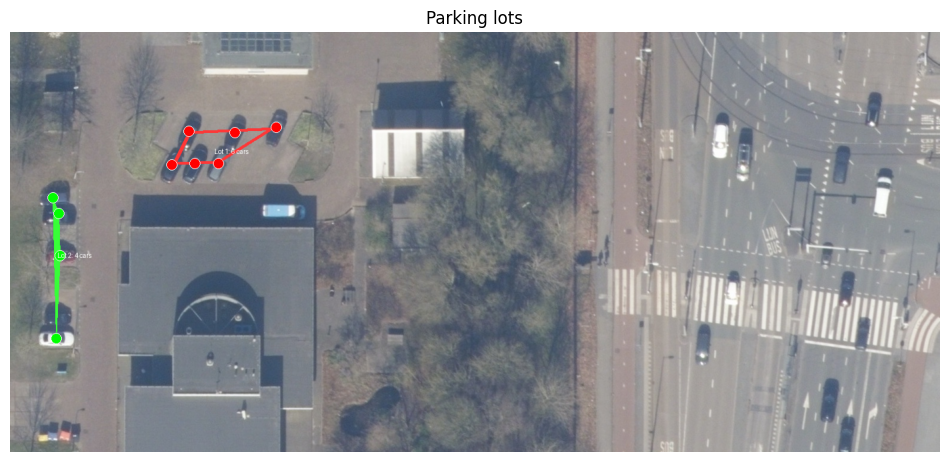

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.imshow(parking_lot_image)
plt.title('Parking lots')
plt.axis('off')
plt.show()